In [39]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sqlalchemy import create_engine, MetaData, Table, select, and_
from sqlalchemy.orm import sessionmaker

In [40]:
# Conexión a la base de datos SQLite
DATABASE_PATH = "../mlruns.db"
engine = create_engine(f"sqlite:///{DATABASE_PATH}")

# Metadatos para acceder a las tablas
metadata = MetaData()
metadata.reflect(bind=engine)

# Referencias a las tablas
metrics = metadata.tables['metrics']
runs = metadata.tables['runs']
params = metadata.tables['params']




In [41]:
# Consulta para obtener los datos
with engine.connect() as connection:
    query = (
        select(
            runs.c.run_uuid,
            runs.c.status,
            runs.c.experiment_id,
            runs.c.name.label("run_name"),
            metrics.c.key.label("metric_key"),
            metrics.c.value.label("metric_value"),
            metrics.c.step,
        )
        .select_from(
            metrics.join(runs, metrics.c.run_uuid == runs.c.run_uuid)
        )
        .where(
            and_(
                runs.c.name.like("latent%-1"),
                runs.c.status == "FINISHED"
            )
        )
    )
    result = connection.execute(query)
    data = result.fetchall()

# Convertir los resultados a un DataFrame de Pandas
df = pd.DataFrame(data, columns=result.keys())

# Visualizar el DataFrame
display(df.head())


,run_uuid,status,experiment_id,run_name,metric_key,metric_value,step
0,0360d77ee3cc4bbf96de3886c7ee868a,FINISHED,1,latent16,train_loss,0.164136,0
1,0360d77ee3cc4bbf96de3886c7ee868a,FINISHED,1,latent16,train_loss_loss,0.164136,0
2,0360d77ee3cc4bbf96de3886c7ee868a,FINISHED,1,latent16,train_ce_loss,640.395995,0
3,0360d77ee3cc4bbf96de3886c7ee868a,FINISHED,1,latent16,train_loss_ce_loss,640.395995,0
4,0360d77ee3cc4bbf96de3886c7ee868a,FINISHED,1,latent16,train_F1,0.730284,0


In [42]:
df.metric_key.unique()

array(['train_loss', 'train_loss_loss', 'train_ce_loss',
       'train_loss_ce_loss', 'train_F1', 'train_loss_F1',
       'train_Accuracy', 'train_loss_Accuracy', 'train_Accuracy_seq',
       'train_loss_Accuracy_seq', 'train_Precision',
       'train_loss_Precision', 'train_Recall', 'train_loss_Recall',
       'valid_loss_loss', 'valid_loss_ce_loss', 'valid_loss_F1',
       'valid_loss_Accuracy', 'valid_loss_Accuracy_seq',
       'valid_loss_Precision', 'valid_loss_Recall'], dtype=object)

In [46]:
df_ = df.query('metric_key in ["train_loss_loss", "valid_loss_loss"] & run_name not in ["latent2","latent4", "latent16-1"]')

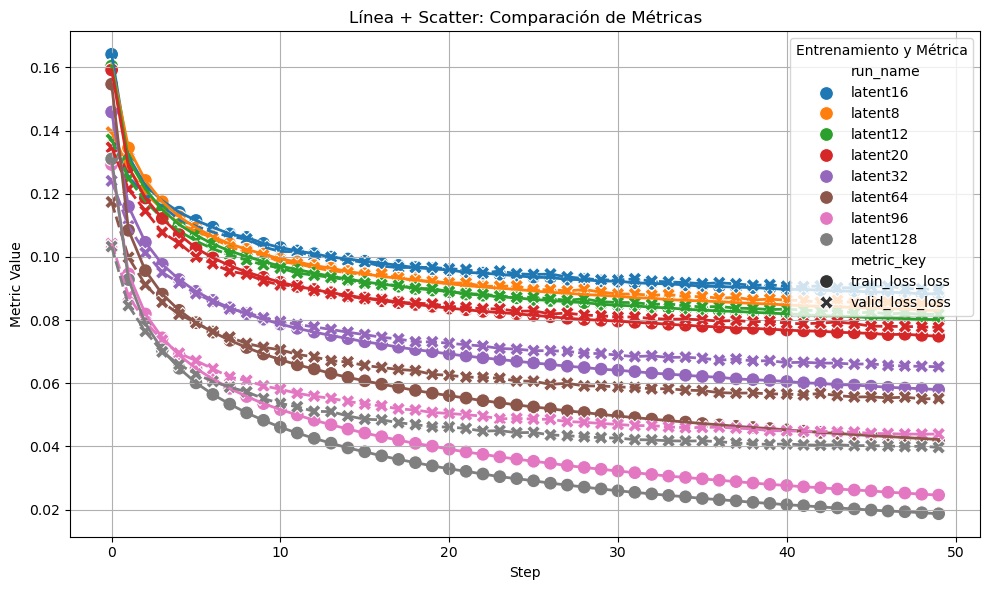

In [47]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_,
    x="step",
    y="metric_value",
    hue="run_name",
    style="metric_key",
    palette="tab10",
    linewidth=2,
    legend=False
)
sns.scatterplot(
    data=df_,
    x="step",
    y="metric_value",
    hue="run_name",
    style="metric_key",
    palette="tab10",
    s=100
)
plt.title("Línea + Scatter: Comparación de Métricas")
plt.xlabel("Step")
plt.ylabel("Metric Value")
plt.legend(title="Entrenamiento y Métrica")
plt.grid(True)
plt.tight_layout()
plt.show()


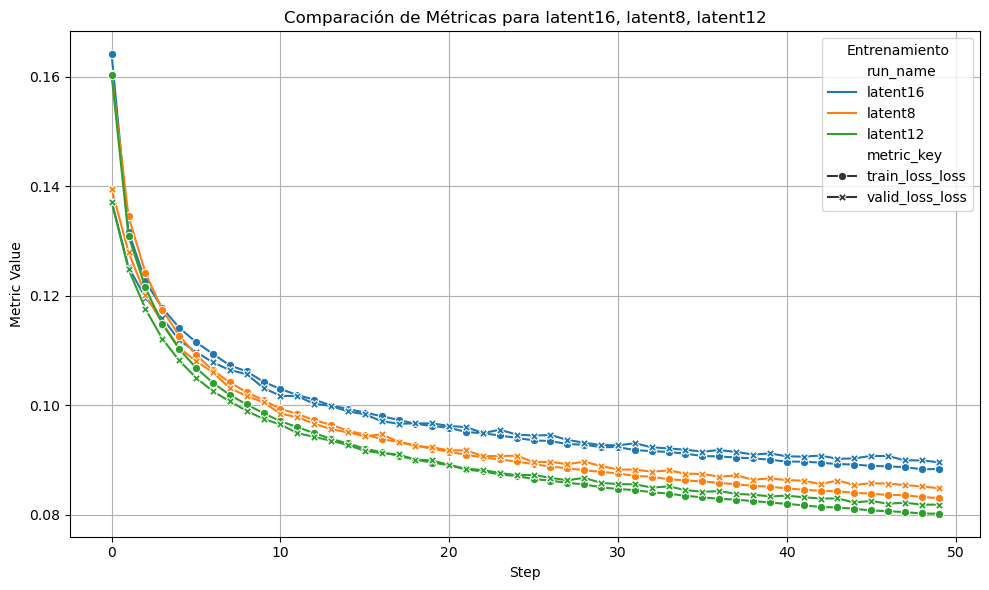

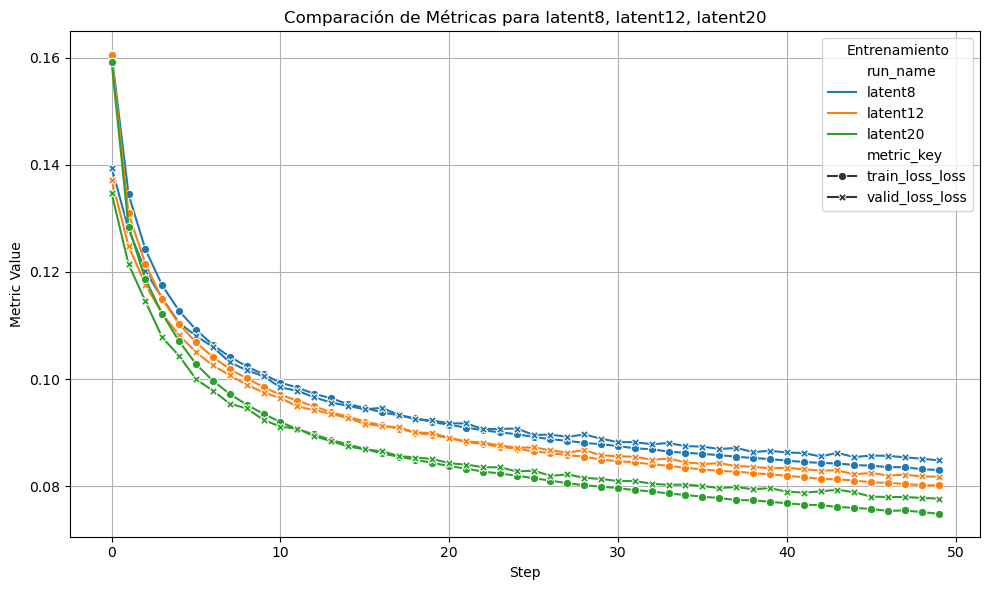

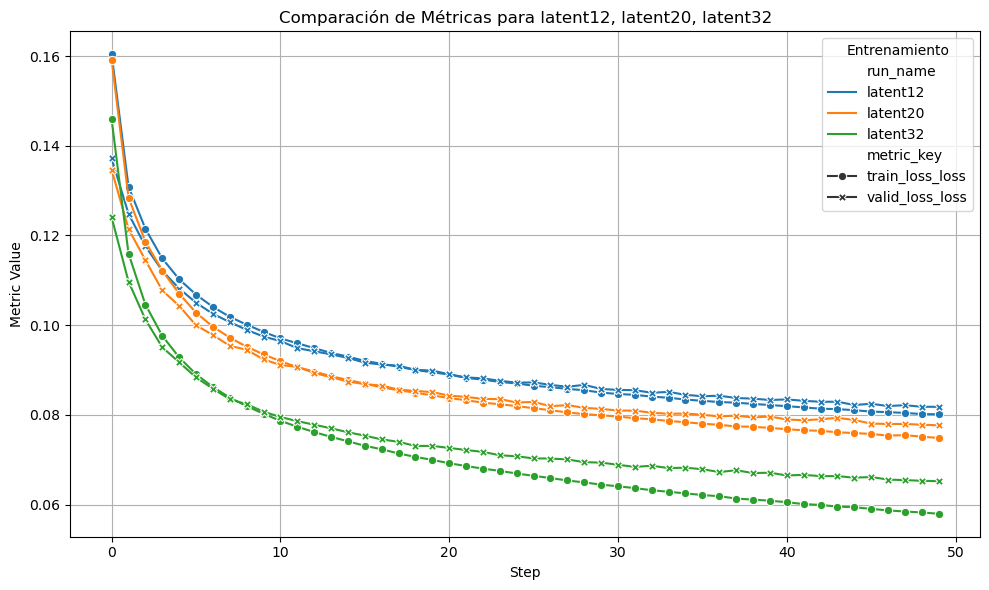

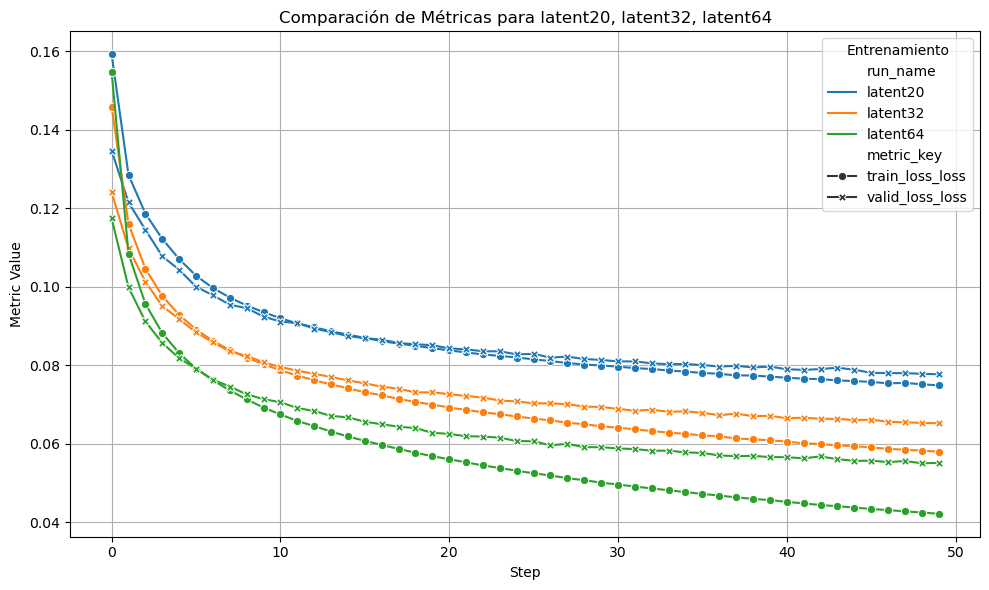

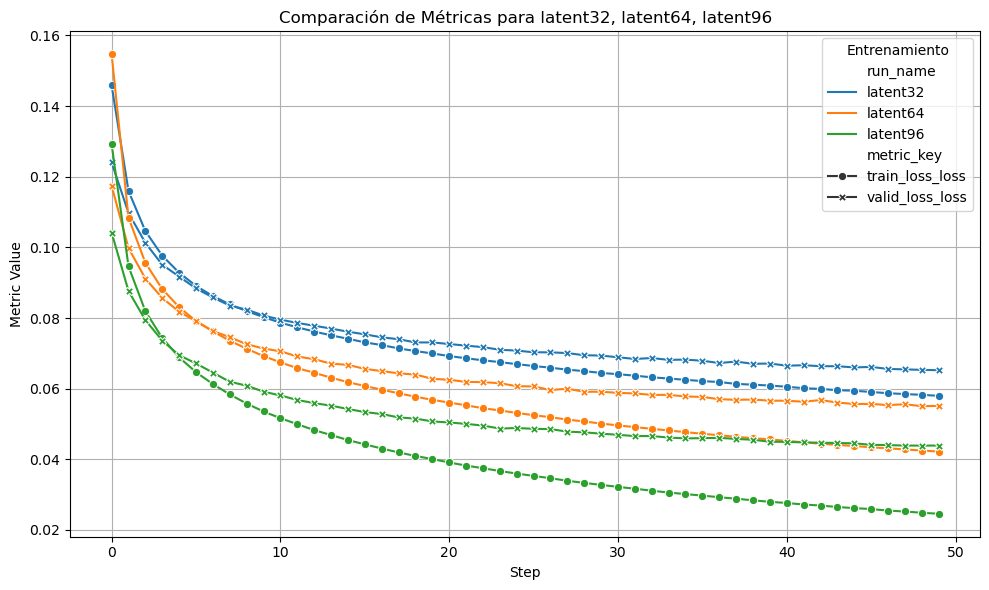

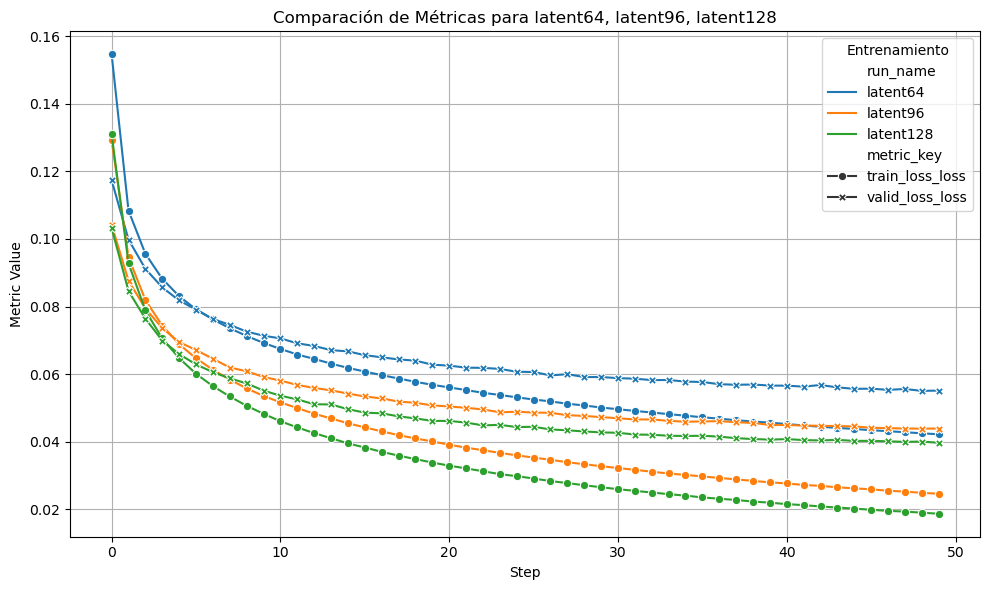

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de nombres de run_name
run_names = df_.run_name.unique()

# Iterar por grupos de 3
for i in range(len(run_names) - 2):
    group = run_names[i:i + 3]
    
    # Filtrar el DataFrame para incluir solo los nombres en el grupo actual
    df_group = df_[df_['run_name'].isin(group)]
    
    # Crear el gráfico
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=df_group,
        x='step',
        y='metric_value',
        hue='run_name',
        style='metric_key',
        markers=True,
        dashes=False,
        palette="tab10"
    )
    plt.title(f"Comparación de Métricas para {', '.join(group)}")
    plt.xlabel("Step")
    plt.ylabel("Metric Value")
    plt.legend(title="Entrenamiento")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
